In this notebook, let us explore the given data and understand it so as to build our models. 

**Objective:**

Develop algorithms to classify genetic mutations based on clinical evidence (text)

First let us import the necessary modules.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

Let us list the files present in the input folder.

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

submissionFile
test_text
test_variants
training_text
training_variants



Let us first read the files as pandas dataframes. 

In [3]:
train_variants_df = pd.read_csv("../input/training_variants")
test_variants_df = pd.read_csv("../input/test_variants")
train_text_df = pd.read_csv("../input/training_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
test_text_df = pd.read_csv("../input/test_text", sep="\|\|", engine='python', header=None, skiprows=1, names=["ID","Text"])
print("Train and Test variants shape : ",train_variants_df.shape, test_variants_df.shape)
print("Train and Test text shape : ",train_text_df.shape, test_text_df.shape)

Train and Test variants shape :  (3321, 4) (5668, 3)
Train and Test text shape :  (3321, 2) (5668, 2)


In [4]:
train_variants_df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
train_text_df.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


Looks like the text field is long. So let us take a single row and check the text column for understanding.

In [6]:
counter = 0
with open("../input/training_text") as infile:
    while True:
        counter += 1
        line = infile.readline()
        print(line)
        if counter==2:
            break

ID,Text

0||Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing pheno

Wow. This is huge.! Before we analyze more about the text, let us first check the class distribution.

**Class Distribution:**

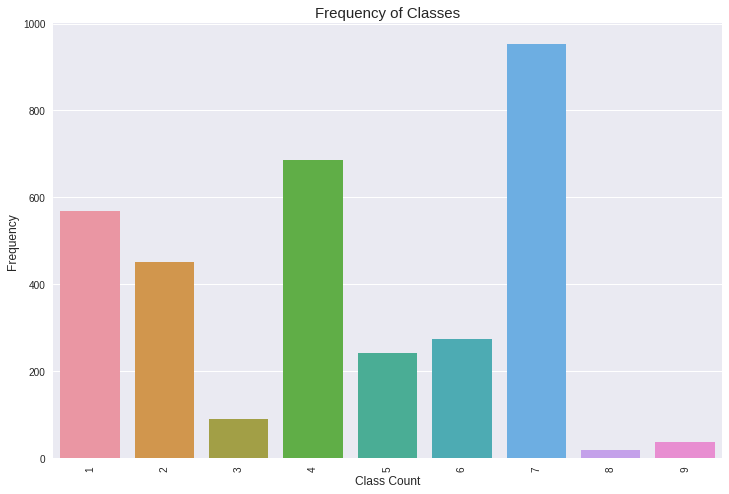

In [7]:
plt.figure(figsize=(12,8))
sns.countplot(x="Class", data=train_variants_df)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Class Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Classes", fontsize=15)
plt.show()

**Gene Distribution:**


Genes that appear less than 2 times: 26.89%
Genes that appear less than 5 times: 53.03%
Genes that appear less than 10 times: 71.59%
Genes that appear less than 20 times: 82.95%
Genes that appear less than 50 times: 95.08%
Genes that appear less than 100 times: 98.11%
Genes that appear less than 300 times: 100.0%


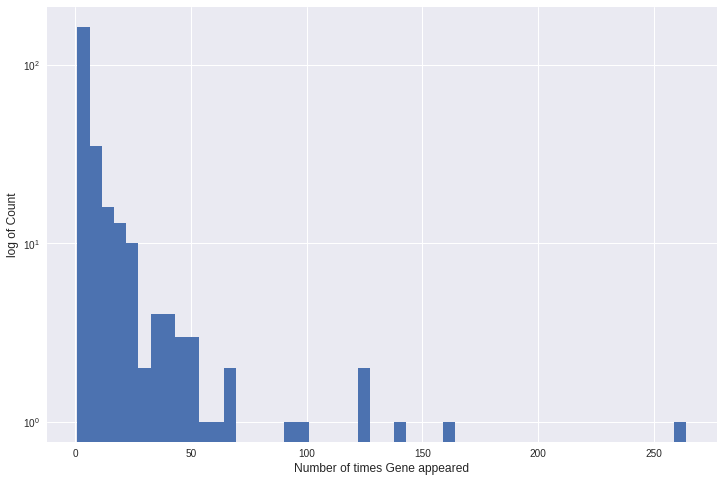

In [8]:
train_genes = train_variants_df.groupby('Gene')['Gene'].count()

for i in [2, 5, 10, 20, 50, 100, 300]:
    print('Genes that appear less than {} times: {}%'.format(i, round((train_genes < i).mean() * 100, 2)))

plt.figure(figsize=(12, 8))
plt.hist(train_genes.values, bins=50, log=True)
plt.xlabel('Number of times Gene appeared', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()

Genes that appear less than 2 times: 98.33%
Genes that appear less than 3 times: 99.63%
Genes that appear less than 5 times: 99.83%
Genes that appear less than 50 times: 99.9%
Genes that appear less than 100 times: 100.0%


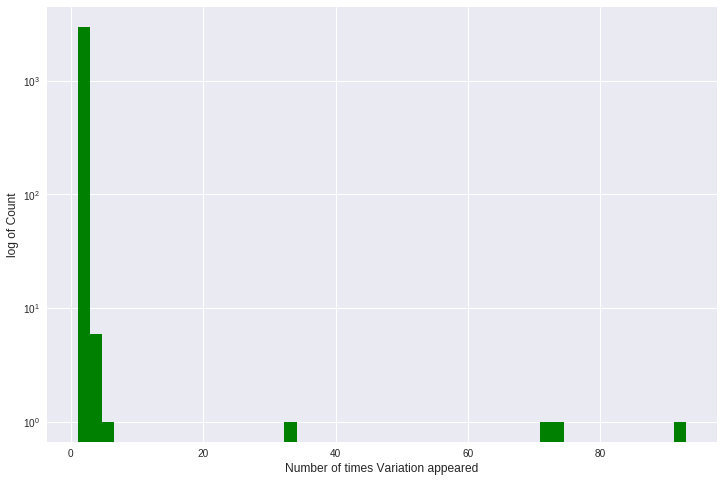

In [9]:
train_variation = train_variants_df.groupby('Variation')['Variation'].count()

for i in [2,3,5,50,100]:
    print('Genes that appear less than {} times: {}%'.format(i, round((train_variation < i).mean() * 100, 2)))

plt.figure(figsize=(12, 8))
plt.hist(train_variation.values, bins=50, log=True, color='green')
plt.xlabel('Number of times Variation appeared', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.show()

Majority of the times, the number of occurrences of the variations are less than 5. 

Now let us do some exploration on the text column.

In [10]:
train_text_df["Text_num_words"] = train_text_df["Text"].apply(lambda x: len(str(x).split()) )
train_text_df["Text_num_chars"] = train_text_df["Text"].apply(lambda x: len(str(x)) )

Let us look at the distribution of number of words in the text column.

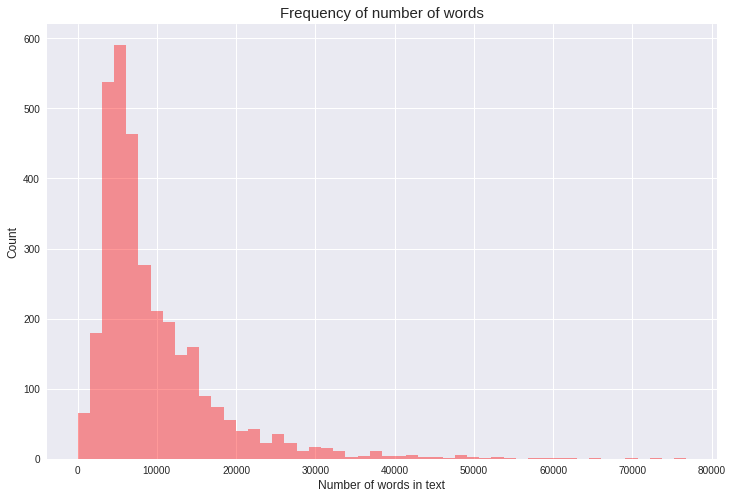

In [11]:
plt.figure(figsize=(12, 8))
sns.distplot(train_text_df.Text_num_words.values, bins=50, kde=False, color='red')
plt.xlabel('Number of words in text', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title("Frequency of number of words", fontsize=15)
plt.show()

The peak is around 4000 words. Now let us look at character level.

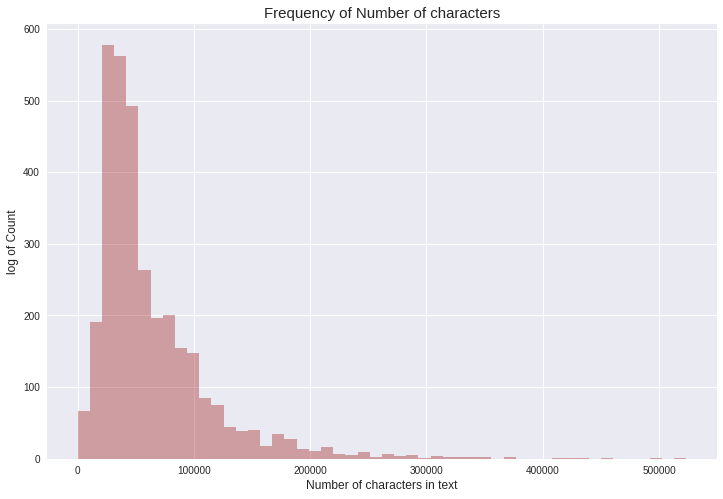

In [12]:
plt.figure(figsize=(12, 8))
sns.distplot(train_text_df.Text_num_chars.values, bins=50, kde=False, color='brown')
plt.xlabel('Number of characters in text', fontsize=12)
plt.ylabel('log of Count', fontsize=12)
plt.title("Frequency of Number of characters", fontsize=15)
plt.show()

The distribution is similar to the previous one. 

Let us now check if we could use the number of words in the text has predictive power.

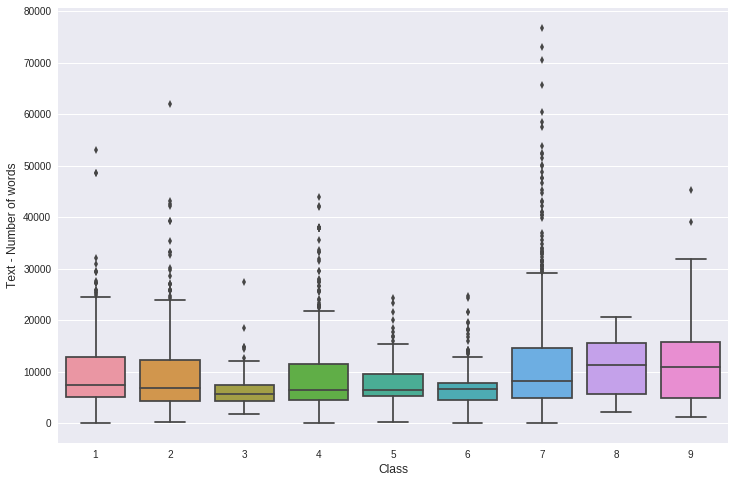

In [13]:
train_df = pd.merge(train_variants_df, train_text_df, on='ID')

plt.figure(figsize=(12,8))
sns.boxplot(x='Class', y='Text_num_words', data=train_df)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Text - Number of words', fontsize=12)
plt.show()

I think this might be useful to discriminate some of the classes like class 3, 6 from others. So might be good to have in the input features. 

**More to come. Stay tuned.!**